# Problem 3

**Problem 3** is essentially a meat consumption forecasting problem for each user. We'll start by verifying the datasets.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/robi-datathon-30-qualifier-problem-3/boxes.csv
/kaggle/input/robi-datathon-30-qualifier-problem-3/purchase.csv
/kaggle/input/robi-datathon-30-qualifier-problem-3/problem 3.csv
/kaggle/input/robi-datathon-30-qualifier-problem-3/sample submission 3.csv


The next few segments will start by importing the datasets.

In [3]:
boxes_df = pd.read_csv('/kaggle/input/robi-datathon-30-qualifier-problem-3/boxes.csv')
boxes_df.head()

,BOX_ID,QUALITY,DELIVERY_OPTION,MILK,MEAT,UNIT_PRICE
0,1,Premium,Home Delivery - CoD,0.0,2.7,9.96
1,2,Premium,Home Delivery - CoD,0.0,2.3,11.96
2,3,Premium,Home Delivery - CoD,0.0,2.4,11.96
3,4,Premium,Home Delivery - CoD,0.0,2.5,11.96
4,5,Premium,Home Delivery - CoD,0.0,2.6,11.96
...,...,...,...,...,...,...
285,286,Standard,Home Delivery - Digital Payment,0.0,4.0,15.96
286,287,Standard,Home Delivery - Digital Payment,0.0,2.9,15.96
287,288,Standard,Home Delivery - Digital Payment,0.0,3.6,15.96
288,289,Standard,Home Delivery - Digital Payment,0.0,4.7,15.96


In [4]:
purchase_df = pd.read_csv('/kaggle/input/robi-datathon-30-qualifier-problem-3/purchase.csv')
purchase_df.head()

,PURCHASE_DATE,MAGIC_KEY,BOX_ID,BOX_COUNT
0,1/2/2019,2CED678A247,12.0,1.0
1,1/2/2019,2BF58D91BA1,12.0,1.0
2,1/2/2019,2C15B86534E,99.0,1.0
3,1/2/2019,2C32D9A859A,6.0,1.0
4,1/2/2019,2C7A55404D1,4.0,1.0
...,...,...,...,...
2455859,28/10/2018,2BD992B5538,12.0,1.0
2455860,28/10/2018,2C97CD72233,17.0,1.0
2455861,28/10/2018,2C91C61D372,40.0,1.0
2455862,28/10/2018,2CD70CFC4E3,51.0,1.0


## Test Data Cursory Observation

It seems that there are **no features** that we can use throughout the **prediction period** since only the IDs of the customers to predict for have been given. This generally **rules out any traditional machine learning approaches** that require features on the test set to be present to make predictions. What we do have, however, is the historical data of each customer for a 5 month window. We can essentially model this into a **time-series forecasting problem** since the number of univariate predictions to make is quite low.

In [5]:
test_df = pd.read_csv('/kaggle/input/robi-datathon-30-qualifier-problem-3/problem 3.csv')
test_df.head()

,MAGIC_KEY
0,2BCFE9C06A7
1,2C2A872B5A2
2,2C6A897671B
3,2C6F1287F53
4,2C658198CC9
...,...
5374,2C0804EFE49
5375,2C080B48630
5376,2C08243C58E
5377,2C082C78575


## Purchase History
For convenience, we will merge the box dataset with the customer dataset to get a holistic idea of their purchase history. This will act as the single source of truth from here on.

In [6]:
merged_df = pd.merge(boxes_df, purchase_df, on='BOX_ID', how='inner')
merged_df = pd.merge(merged_df, test_df, on='MAGIC_KEY', how='inner')
merged_df['PURCHASE_DATE'] = pd.to_datetime(merged_df['PURCHASE_DATE'], format='%d/%m/%Y')
merged_df.sort_values(by='PURCHASE_DATE', inplace=True)
merged_df.head()

,BOX_ID,QUALITY,DELIVERY_OPTION,MILK,MEAT,UNIT_PRICE,PURCHASE_DATE,MAGIC_KEY,BOX_COUNT
8132,118,Premium,Delivery from Collection Point,8.0,1.3,15.98,2018-10-01,2BD74F59939,1.0
14488,238,Standard,Delivery from Collection Point,10.7,0.0,12.78,2018-10-01,29109B11876,1.0
8777,132,Premium,Delivery from Collection Point,9.0,1.8,19.98,2018-10-01,2C2A872B5A2,1.0
2115,28,Premium,Home Delivery - CoD,0.0,3.3,15.96,2018-10-01,2C31984A82F,1.0
14487,238,Standard,Delivery from Collection Point,10.7,0.0,12.78,2018-10-01,28E64A5A9AF,1.0
...,...,...,...,...,...,...,...,...,...
3404,56,Premium,Delivery from Collection Point,10.0,3.6,15.00,2019-02-28,2BC82E22FE6,4.0
3403,56,Premium,Delivery from Collection Point,10.0,3.6,15.00,2019-02-28,2C9D8A0D2CA,2.0
3402,56,Premium,Delivery from Collection Point,10.0,3.6,15.00,2019-02-28,2CC97F26BF0,1.0
3368,56,Premium,Delivery from Collection Point,10.0,3.6,15.00,2019-02-28,2BD482F4B0E,1.0


## Target Variable Analysis
Now to explore the variable in question, the **meat consumption** of the sample. The statical analysis of *meat* for the test users are provided:

In [7]:
merged_df['MEAT'].describe()

count    15353.000000
mean         1.517547
std          1.322710
min          0.000000
25%          0.000000
50%          1.800000
75%          2.400000
max          5.800000
Name: MEAT, dtype: float64

It seems that the target variable does not exhibit much deviation. There is an interesting insight, though — **the 25th percentile of the target variable is 0.00**. This suggests that there's a lot of purchases where the meat consumption is zero. Let's have a deeper look.

Zero meat purchases: 38.187976291278574%


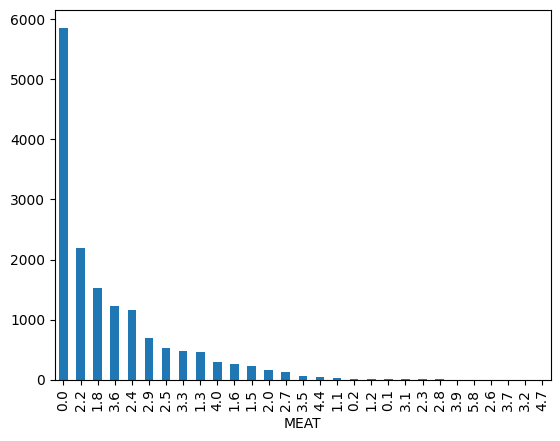

In [8]:
meat_bins = merged_df['MEAT'].value_counts()
print(f"Zero meat purchases: { meat_bins[0] / len(merged_df['MEAT']) * 100}%")
meat_bins.plot(kind='bar')
plt.show()

So, **around 38%** of the meat values in the customer purchase history are zeroes. This gives us an indication that the amount of zeroes in the predicted timeline should also be high given that a significant chunk of the customers don't make purchases with much meat in them.

We can restructure the time-series data in a way that gives us many data points so that predictive mechanisms can capture the periodicity well. We can simply take the daily volume of milk that a person purchases, which would be zero on most of the days.

Here, we run a demo on a single random customer.

In [9]:
customer_id = test_df['MAGIC_KEY'].sample(1).iloc[0]
customer_label = 'MEAT'
customer_id

'2CCBF8589B5'

In [10]:
def get_daily_volume_customer(c_id, debug=False, label='MEAT'):
    c_history = merged_df[merged_df['MAGIC_KEY'] == c_id]
    c_daily_volume = c_history[['PURCHASE_DATE', label]].resample('D', on='PURCHASE_DATE').sum().reset_index()
    min_date = pd.to_datetime('2018-10-01')
    max_date = pd.to_datetime('2019-02-28')
    date_range_df = pd.DataFrame(pd.date_range(start=min_date, end=max_date, freq='D'), columns=['PURCHASE_DATE'])
    c_daily_volume = pd.merge(date_range_df, c_daily_volume, on='PURCHASE_DATE', how='left')
    c_daily_volume.fillna(0, inplace=True)
    c_daily_volume.set_index('PURCHASE_DATE', inplace=True)
    if debug:
        seasonal_decompose(c_daily_volume[label], model='additive').plot()
        plt.xticks(rotation=90)
        plt.show()
    return c_daily_volume

customer_daily_volume = get_daily_volume_customer(customer_id, debug=False, label=customer_label)
customer_daily_volume

,MEAT
PURCHASE_DATE,
2018-10-01,0.0
2018-10-02,0.0
2018-10-03,0.0
2018-10-04,0.0
2018-10-05,0.0
...,...
2019-02-24,0.0
2019-02-25,0.0
2019-02-26,0.0


## Model Selection

For our model selection, we choose [Prophet](https://facebook.github.io/prophet/). It addresses seasonality, is scalable and claims to be robust to outliers, which suits our needs for this particular task. Before running the prediction on the whole dataset, we choose to run it on one of the samples that we had taken randomly and calculated the RMSE for each of the forecasted values.

In [11]:
model_prophet = Prophet()
model_prophet.fit(customer_daily_volume.reset_index().rename(columns={'PURCHASE_DATE': 'ds', 'MEAT': 'y'}))
future = model_prophet.make_future_dataframe(periods=30)
forecast = model_prophet.predict(future)
forecast['PRED'] = forecast['yhat'].clip(lower=0)
forecast[['ds', 'PRED']].tail(30)

,ds,PRED
151,2019-03-01,0.0
152,2019-03-02,0.0
153,2019-03-03,0.0
154,2019-03-04,0.0
155,2019-03-05,0.0
156,2019-03-06,0.0
157,2019-03-07,0.0
158,2019-03-08,0.0
159,2019-03-09,0.0
160,2019-03-10,0.0


In [12]:
cmp1 = customer_daily_volume[(customer_daily_volume.index >= pd.to_datetime('2019-02-01')) & (customer_daily_volume.index <= pd.to_datetime('2019-02-28'))].reset_index()
cmp2 = forecast[(forecast['ds'] >= pd.to_datetime('2019-02-01')) & (forecast['ds'] <= pd.to_datetime('2019-02-28'))][['ds', 'PRED']]
cmp_joined = pd.merge(cmp1, cmp2, left_on='PURCHASE_DATE', right_on='ds', how='inner')
print(f'rmse: {((cmp_joined["MEAT"].sum() - cmp_joined["PRED"].sum()) ** 2).mean() ** .5}')
cmp_joined

rmse: 0.0


,PURCHASE_DATE,MEAT,ds,PRED
0,2019-02-01,0.0,2019-02-01,0.0
1,2019-02-02,0.0,2019-02-02,0.0
2,2019-02-03,0.0,2019-02-03,0.0
3,2019-02-04,0.0,2019-02-04,0.0
4,2019-02-05,0.0,2019-02-05,0.0
5,2019-02-06,0.0,2019-02-06,0.0
6,2019-02-07,0.0,2019-02-07,0.0
7,2019-02-08,0.0,2019-02-08,0.0
8,2019-02-09,0.0,2019-02-09,0.0
9,2019-02-10,0.0,2019-02-10,0.0


The RMSE tends to be around 1.5 for most samples, which is reasoable for this task, so it we had decided to not tune it any further and rely on the OOTB parameters instead.

## Additional Filtering

Before running predictive models like Prophet on the entire dataset, we assess which solutions we might have deterministically at our disposal to get filter out as many values as possible with trivial cases and some strong assumptions that are likely to hold.

In [13]:
per_person_purchase = pd.DataFrame(merged_df.groupby('MAGIC_KEY').size().reset_index()).rename(columns={0: 'PURCHASE_COUNT'})
per_person_unique = pd.DataFrame(merged_df.groupby('MAGIC_KEY')['BOX_ID'].nunique().reset_index()).rename(columns={'BOX_ID': 'PURCHASE_COUNT_UNIQUE'})
per_person = pd.merge(per_person_purchase, per_person_unique, on='MAGIC_KEY', how='inner')
person_monotone = per_person[per_person['PURCHASE_COUNT_UNIQUE'] == 1]
person_monotone

,MAGIC_KEY,PURCHASE_COUNT,PURCHASE_COUNT_UNIQUE
1,24D1CF7CA25,2,1
2,24D279F5F06,1,1
5,28CF4A2D077,1,1
6,28CFD58918B,1,1
7,28D1D4499D4,1,1
...,...,...,...
5365,2D4CB81B1AC,1,1
5372,2E19F98075D,5,1
5373,2E224CE9C74,1,1
5375,2E5E4A47984,1,1


In [16]:
print(f'Mono %: {len(person_monotone) / len(test_df) * 100}')

Mono %: 61.256739170849606


We start by filtering out the people who have only made a purchase of a single type of box. That nets us around ~3.3k customers. That's a **staggering 61%** of the entire sample.

In [14]:
person_varied = per_person[per_person['PURCHASE_COUNT_UNIQUE'] > 1]
merged_df_meat = pd.DataFrame(merged_df.groupby('MAGIC_KEY', as_index=False)['MEAT'].sum())
merged_df_meat = merged_df_meat[merged_df_meat['MEAT'] > 0]
person_varied_meat = pd.merge(person_varied, merged_df_meat, on='MAGIC_KEY', how='inner').drop(columns='MEAT')
person_varied_meat

,MAGIC_KEY,PURCHASE_COUNT,PURCHASE_COUNT_UNIQUE
0,27D86DD37C9,3,2
1,28CF0640F8B,4,4
2,28D44CC0F7F,2,2
3,28D4D3CDD0C,3,2
4,28D817C64B7,2,2
...,...,...,...
1653,2D73A75A671,2,2
1654,2D7F3886691,5,2
1655,2D82F624BA6,3,2
1656,2E2336C7F7F,21,5


Next we do the opposite and find the consumers who had at least some amount (non-zero) of meat. This causes the remaining number of customers to drop to a meagre ~1.6k entries. We can run our Prophet predictions on these entries since they seem to be the most unpredictable of the bunch.

In [15]:
def predict_prophet_test(gdf):
    customer_daily_volume = get_daily_volume_customer(gdf.name)
    train = customer_daily_volume['2019-01-01':'2019-02-28']
    
    model_prophet = Prophet()
    model_prophet.fit(train.reset_index().rename(columns={'PURCHASE_DATE': 'ds', 'MEAT': 'y'}))
    future = model_prophet.make_future_dataframe(periods=30)
    forecast = model_prophet.predict(future)
    forecast['PRED'] = forecast['yhat'].clip(lower=0)
    
    forecast_target = forecast[(forecast['ds'] >= pd.to_datetime('2019-03-01')) & (forecast['ds'] <= pd.to_datetime('2019-03-15'))][['ds', 'PRED']]
    meat_pred = max(forecast_target["PRED"].sum(), 0)
    gdf['MEAT_PRED'] = meat_pred
    gdf['MAGIC_KEY'] = gdf.name
    return gdf

person_varied_history_test = pd.merge(person_varied_meat, merged_df, on='MAGIC_KEY', how='inner')
person_varied_history_test_group = person_varied_history_test.groupby('MAGIC_KEY', as_index=False)

prophesized_test = person_varied_history_test_group.apply(predict_prophet_test, include_groups=False).reset_index().drop(columns=['level_0', 'level_1'])[['MAGIC_KEY', 'MEAT_PRED']].drop_duplicates(subset=['MAGIC_KEY'])
prophesized_test

03:08:01 - cmdstanpy - INFO - Chain [1] start processing
03:08:01 - cmdstanpy - INFO - Chain [1] done processing
03:08:01 - cmdstanpy - INFO - Chain [1] start processing
03:08:02 - cmdstanpy - INFO - Chain [1] done processing
03:08:02 - cmdstanpy - INFO - Chain [1] start processing
03:08:02 - cmdstanpy - INFO - Chain [1] done processing
03:08:03 - cmdstanpy - INFO - Chain [1] start processing
03:08:03 - cmdstanpy - INFO - Chain [1] done processing
03:08:04 - cmdstanpy - INFO - Chain [1] start processing
03:08:04 - cmdstanpy - INFO - Chain [1] done processing
03:08:04 - cmdstanpy - INFO - Chain [1] start processing
03:08:04 - cmdstanpy - INFO - Chain [1] done processing
03:08:05 - cmdstanpy - INFO - Chain [1] start processing
03:08:06 - cmdstanpy - INFO - Chain [1] done processing
03:08:06 - cmdstanpy - INFO - Chain [1] start processing
03:08:06 - cmdstanpy - INFO - Chain [1] done processing
03:08:07 - cmdstanpy - INFO - Chain [1] start processing
03:08:07 - cmdstanpy - INFO - Chain [1]

,MAGIC_KEY,MEAT_PRED
0,27D86DD37C9,0.000000
3,28CF0640F8B,1.469160
7,28D44CC0F7F,2.704839
9,28D4D3CDD0C,1.073143
12,28D817C64B7,0.000000
...,...,...
7649,2D73A75A671,1.793998
7651,2D7F3886691,0.390006
7656,2D82F624BA6,2.826814
7659,2E2336C7F7F,3.080682


In [17]:
prophesized_test.to_csv('prophesized_test.csv', index=False)

We then start merging these predicted results with other predictions found from other trivial approaches.

In [18]:
person_monotone_history = pd.merge(person_monotone, merged_df, on='MAGIC_KEY', how='inner')
meat_monotone_pred = person_monotone_history.drop_duplicates(subset='MAGIC_KEY')[['MAGIC_KEY', 'MEAT']]
meat_monotone_pred

,MAGIC_KEY,MEAT
0,24D1CF7CA25,0.0
2,24D279F5F06,1.3
3,28CF4A2D077,0.0
4,28CFD58918B,0.0
5,28D1D4499D4,0.0
...,...,...
4193,2D4CB81B1AC,3.6
4194,2E19F98075D,0.0
4199,2E224CE9C74,2.2
4200,2E5E4A47984,3.6


In [19]:
_merged_df_meat = pd.DataFrame(merged_df.groupby('MAGIC_KEY', as_index=False)['MEAT'].sum())
meat_none = _merged_df_meat[_merged_df_meat['MEAT'] == 0][['MAGIC_KEY', 'MEAT']]
meat_none_pred = pd.merge(person_varied, meat_none, on='MAGIC_KEY', how='inner')[['MAGIC_KEY', 'MEAT']]
meat_none_pred

,MAGIC_KEY,MEAT
0,2499B9E0C1C,0.0
1,28D23EC2ED4,0.0
2,28D3BEA55EF,0.0
3,28E1B113EA6,0.0
4,28E3457C68A,0.0
...,...,...
420,2CF681C94AD,0.0
421,2CF9CD8B075,0.0
422,2CFE011A996,0.0
423,2D003E8F2CE,0.0


These entries are based on the assumption that a person **who has never consumed meat thus far despite making purchases is highly unlikely** to do so in the first two weeks of March as well. There isn't enough auxiliary data for us to assess any case that would predict otherwise.

In [20]:
meat_varied_pred = prophesized_test.rename(columns={'MEAT_PRED': 'MEAT'})
meat_varied_pred

,MAGIC_KEY,MEAT
0,27D86DD37C9,0.000000
3,28CF0640F8B,1.469160
7,28D44CC0F7F,2.704839
9,28D4D3CDD0C,1.073143
12,28D817C64B7,0.000000
...,...,...
7649,2D73A75A671,1.793998
7651,2D7F3886691,0.390006
7656,2D82F624BA6,2.826814
7659,2E2336C7F7F,3.080682


In [21]:
meat_final_pred = pd.concat([meat_monotone_pred, meat_none_pred, meat_varied_pred])
meat_final_pred = pd.merge(test_df, meat_final_pred, on='MAGIC_KEY', how='left')
meat_final_pred.fillna(0, inplace=True)
meat_final_pred

,MAGIC_KEY,MEAT
0,2BCFE9C06A7,3.600000
1,2C2A872B5A2,0.000000
2,2C6A897671B,2.485290
3,2C6F1287F53,28.483348
4,2C658198CC9,0.580559
...,...,...
5374,2C0804EFE49,2.500000
5375,2C080B48630,0.000000
5376,2C08243C58E,2.400000
5377,2C082C78575,1.800000


In [38]:
meat_final_pred.to_csv('submission.csv', index=False)

After merging all the predictions, an ensembles of both statistical and forecasting-based methods is ultimately we end up going with.